<a href="https://colab.research.google.com/github/Giuliana-24/PROYECTOS_SIC/blob/main/Proy2/NLP_TWEET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO NLP TWITTER**

En este notebook desarrollaré el proceso de clasificación de tweets para evaluar si es un desastre o no



---



## ***1. Carga de datos***

Importamos librerias como panda para manipulacion de datos en dataframes.

Importamos Matplotlib para realizar visualizaciones.

Importamos numpy para facilitar operaciones

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('drive/MyDrive/datasets/train.csv')
df_test = pd.read_csv('drive/MyDrive/datasets/test.csv')
sample_submission = pd.read_csv('drive/MyDrive/datasets/sample_submission.csv')

# Explorar los primeros registros de cada archivo
print(df_train.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [ ]:
faltantes=df_train.isnull().sum()

In [ ]:
df_train.duplicated().sum()

0

Como podemos observar no tenemos valores duplicados, ni faltantes en "text". Apenas tenemos en "keywords", en "location" existen en buena parte datos faltantes, sin emaro como no es la variable a evaluar, no hace falta cambiarla

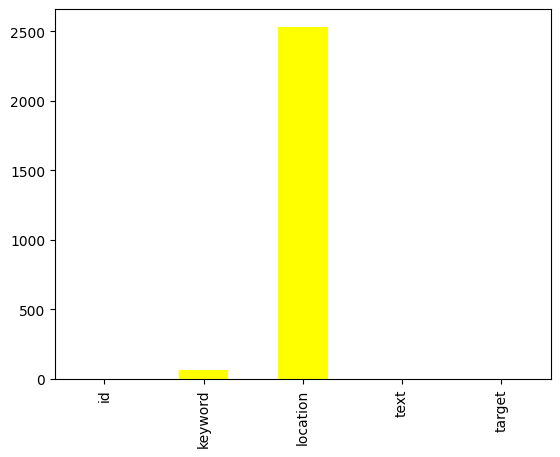

In [ ]:
faltantes.plot(kind='bar', color='yellow')
plt.show()

## ***2. Limpieza de datos***

Aquí veremos un poco más a detalle los datos, lo prepararemos para poder procesarlos. Vamos a eliminar stopwords, aplicar tokenización, lematización, etc.

**Tokenizacion Re y WordTokenize**: Tras observar los datos, ocurre que existen hashta con palabras que podrian ser utiles para el reconocimiento de si es desastre o no. Re es más adecuado ya que permite realizar una eliminiacion de elementos no utiles(url, # y @), como tambien WordTokenize nos permite una tokenizacion mas minuciosa hacia lo que necesitamos.

In [ ]:
import nltk

# Descargar los recursos necesarios para trabajar con NLTK
nltk.download('punkt')          # Datos para la tokenización de oraciones y palabras
nltk.download('stopwords')      # Lista de stopwords en varios idiomas
nltk.download('averaged_perceptron_tagger')  # Modelo para el etiquetado de partes del discurso
nltk.download('wordnet')        # Diccionario léxico para lematización


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Extraer caracteres especiales, urls, @ y # utilizando Re: Esto nos permite analizar el texto tal cual para evitar confusiones por caracteres no alfanumericos, tanto como estandarizamos  todo en minusculas.

In [ ]:
import re

def limpiar_tokens(token):
        #Minusculas
        token=token.lower()
        # Eliminar URLs
        token = re.sub(r"http\S+|www\S+|https\S+", '', token)
        # Eliminar arrobas
        token = re.sub(r'@\w+', '', token)
        # Eliminar #, conservando la palabra
        token = re.sub(r'#', '', token)
        # Eliminar caracteres no deseados
        token = re.sub(r'\W', ' ', token)

        return token

# Aplicamos
df_train['texto_limpio'] = df_train['text'].apply(limpiar_tokens)
df_test['texto_limpio'] = df_test['text'].apply(limpiar_tokens)


print(df_train[['text','texto_limpio']].head())
print(df_test[['text','texto_limpio']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        texto_limpio  
0  our deeds are the reason of this earthquake ma...  
1             forest fire near la ronge sask  canada  
2  all residents asked to  shelter in place  are ...  
3  13 000 people receive wildfires evacuation ord...  
4  just got sent this photo from ruby alaska as s...  
                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4      Typhoon Soudelor kills 28 in China and Taiwan 

A continuacion separaremos las palabras con WordTokenize

In [ ]:
from nltk.tokenize import word_tokenize

# Tokenización usando word_tokenize de NLTK

df_train['tokenizado'] = df_train['texto_limpio'].apply(word_tokenize)
df_test['tokenizado'] = df_test['texto_limpio'].apply(word_tokenize)

# Imprimir texto tokenizado y no tokenizado
print(df_train[['texto_limpio', 'tokenizado']].head(3))
print(df_test[['texto_limpio', 'tokenizado']].head(3))

                                        texto_limpio  \
0  our deeds are the reason of this earthquake ma...   
1             forest fire near la ronge sask  canada   
2  all residents asked to  shelter in place  are ...   

                                          tokenizado  
0  [our, deeds, are, the, reason, of, this, earth...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [all, residents, asked, to, shelter, in, place...  
                                        texto_limpio  \
0                 just happened a terrible car crash   
1  heard about earthquake is different cities  st...   
2  there is a forest fire at spot pond  geese are...   

                                          tokenizado  
0          [just, happened, a, terrible, car, crash]  
1  [heard, about, earthquake, is, different, citi...  
2  [there, is, a, forest, fire, at, spot, pond, g...  


Eliminacion de StopWords: En este caso, utilizamos NLTK por simplicidad. Esto es necesario porque si tenemos el df lleno de palabras sin sinificado relevante, probablemente no haria una muy buen prediccion. Para esto es importante dejar lo importante que permite al texto identificarlo como desastre o no.

In [ ]:
from nltk.corpus import stopwords

# Confi en ingles
stop_words = set(stopwords.words('english'))

def quitar_stopwords(words):
    return [word for word in words if word not in stop_words]

# Aplicar al df_train y df_test
df_train['tokens_limpio'] = df_train['tokenizado'].apply(quitar_stopwords)
df_test['tokens_limpio'] = df_test['tokenizado'].apply(quitar_stopwords)

print(df_train[['tokenizado', 'tokens_limpio']].head())
print(df_test[['tokenizado', 'tokens_limpio']].head())



                                          tokenizado  \
0  [our, deeds, are, the, reason, of, this, earth...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [all, residents, asked, to, shelter, in, place...   
3  [13, 000, people, receive, wildfires, evacuati...   
4  [just, got, sent, this, photo, from, ruby, ala...   

                                       tokens_limpio  
0  [deeds, reason, earthquake, may, allah, forgiv...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [residents, asked, shelter, place, notified, o...  
3  [13, 000, people, receive, wildfires, evacuati...  
4  [got, sent, photo, ruby, alaska, smoke, wildfi...  
                                          tokenizado  \
0          [just, happened, a, terrible, car, crash]   
1  [heard, about, earthquake, is, different, citi...   
2  [there, is, a, forest, fire, at, spot, pond, g...   
3         [apocalypse, lighting, spokane, wildfires]   
4  [typhoon, soudelor, kills, 28, in, china, and,... 

Lemmatization: Es importante colocar las palabras de forma base para así evitar confusiones entre terminos que a penas varian pero son reconocidos como diferente. Para esta situacion usare NLTK.


In [ ]:
from nltk.stem import WordNetLemmatizer

# Crear lematizador
lemmatizer = WordNetLemmatizer()

def lematizar_tokens(tokens):
    tokens_le = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens_le

# Lematizar tokens limpios
df_train['tokens_lem'] = df_train['tokens_limpio'].apply(lematizar_tokens)
df_test['tokens_lem'] = df_test['tokens_limpio'].apply(lematizar_tokens)

#Ver tokens limpios y lematizados
print(df_train[['tokens_lem','tokens_limpio']].head())
print(df_test[['tokens_lem','tokens_limpio']].head())

                                          tokens_lem  \
0  [deed, reason, earthquake, may, allah, forgive...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [resident, asked, shelter, place, notified, of...   
3  [13, 000, people, receive, wildfire, evacuatio...   
4  [got, sent, photo, ruby, alaska, smoke, wildfi...   

                                       tokens_limpio  
0  [deeds, reason, earthquake, may, allah, forgiv...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [residents, asked, shelter, place, notified, o...  
3  [13, 000, people, receive, wildfires, evacuati...  
4  [got, sent, photo, ruby, alaska, smoke, wildfi...  
                                          tokens_lem  \
0                   [happened, terrible, car, crash]   
1  [heard, earthquake, different, city, stay, saf...   
2  [forest, fire, spot, pond, goose, fleeing, acr...   
3          [apocalypse, lighting, spokane, wildfire]   
4       [typhoon, soudelor, kill, 28, china, taiwan] 

Vectoriza: Para poder vectorizar nuestros datos, debo devolverlo a tipo cadena. Despues de eso se aplica el vectorizador. Que nos permite reconocer las palabras más recurrentes que puede tener el texto.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
vectorizador = TfidfVectorizer()

# Convertir listas de tokens de nuevo a texto
df_train['texto_cadena'] = df_train['tokens_lem'].apply(lambda x: ' '.join(x))
df_test['texto_cadena'] = df_test['tokens_lem'].apply(lambda x: ' '.join(x))

# Ajustar y transformar el texto en el conjunto de entrenamiento
X_train = vectorizador.fit_transform(df_train['texto_cadena'])

# Transformar el texto en el conjunto de prueba
X_test = vectorizador.transform(df_test['texto_cadena'])

# Ver las dimensiones de los datos transformados
print(X_train.shape)  # Datos de entrenamiento
print(X_test.shape)   # Datos de prueba




(7613, 13453)
(3263, 13453)


In [ ]:
# Definir la variable objetivo
y_train = df_train['target']

# Verificar la distribución de las clases
print(y_train.value_counts())


target
0    4342
1    3271
Name: count, dtype: int64


Division de datos con train_test_split 😄:

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir los datos
X_train_split, X_vali, y_train_split, y_vali = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ver las dimensiones
print(X_train_split.shape, X_vali.shape)


(6090, 13453) (1523, 13453)


Aplicacion de Modelo de Regresion Logistica:

Este lo elegi ya que semanas atras lo vimos en clase y funcionaba como clasificador, además que efectivo, es simple en su aplicación.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Crear el modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train_split, y_train_split)

# Predecir con datos de validación
y_val_pred = model.predict(X_vali)


**Evaluacion de resultados a traves de metricas**

In [ ]:
from sklearn.metrics import classification_report

# Evaluar el modelo con la validación
print(classification_report(y_vali, y_val_pred))


              precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.84      0.65      0.73       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



In [ ]:

# Hacer predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)

## ***Conteo de desastres y no desastres de datos de entrenamiento***

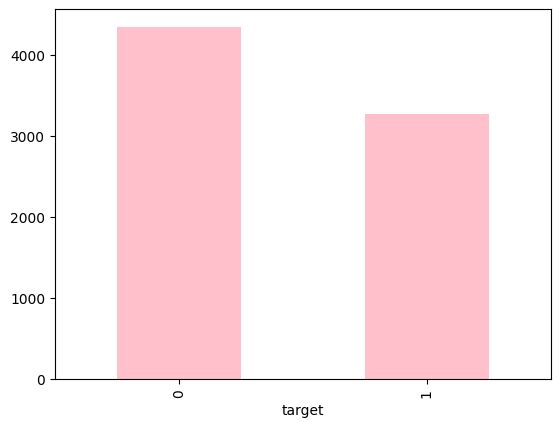

In [ ]:
entreno=df_train['target'].value_counts()
entreno.plot(kind='bar',color='pink')
plt.show()

## ***Conteo de desastres y no desastres de datos de prediccion***

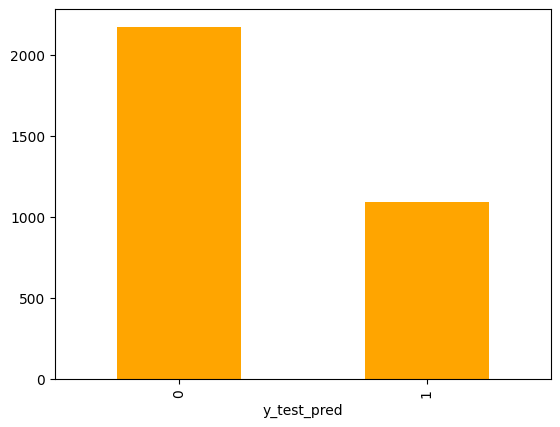

In [ ]:
df_test['y_test_pred']=y_test_pred
predi=df_test['y_test_pred'].value_counts()
predi.plot(kind='bar',color='orange')
plt.show()

In [ ]:
# Copiar el archivo de sample_submission
submission = sample_submission.copy()

# Llenar la columna 'target' con las predicciones
submission['target'] = y_test_pred

# Guardar el archivo CSV para submission
submission.to_csv('submission.csv', index=False)

print("Submission file created!")


Submission file created!


In [ ]:
submi=pd.read_csv('submission.csv')
print(submi['target'].value_counts())


target
0    2174
1    1089
Name: count, dtype: int64
